In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import collections
import numpy as np

from main import plot_segments, plot_lines
from cluster import cluster_segments
from optimize import find_vanishing_points

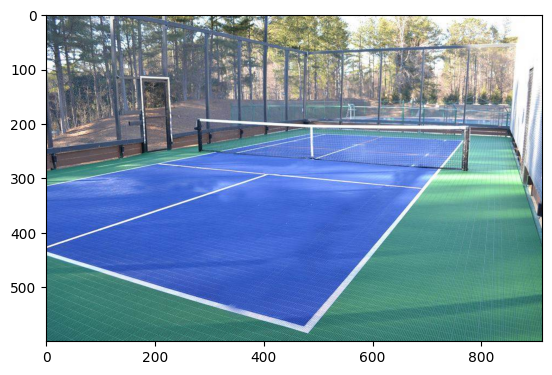

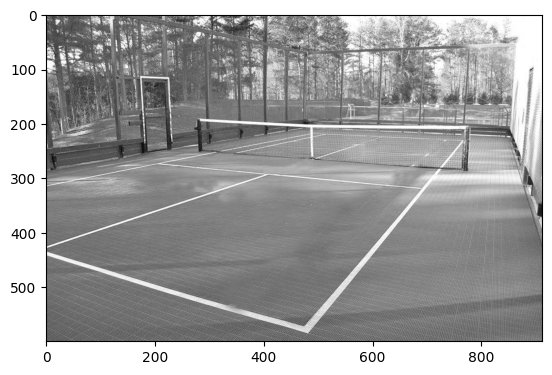

In [4]:
IM_PATH = "pb_court_1.jpg"

im = cv.cvtColor(cv.imread(IM_PATH), cv.COLOR_BGR2RGB)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(im)
plt.figure()
plt.imshow(im_gray, cmap="gray")

# plt.figure()
# im_gaus = cv.GaussianBlur(im, (31, 31), 0)
# im_blur = cv.medianBlur(im_gray, 51)
# im_mask = np.abs(im_gray - im_blur) < 200
# plt.imshow(im_mask, cmap="gray")
# plt.imshow(im_gaus)

1418
2950


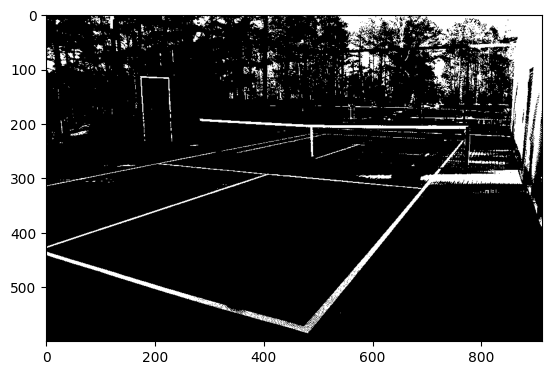

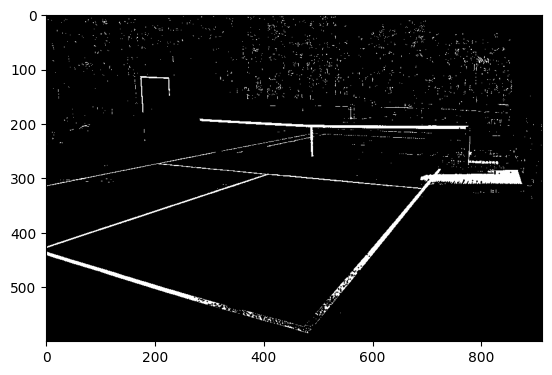

In [5]:
retval, im_thresh = cv.threshold(im_gray, 200, 255, cv.THRESH_BINARY)
plt.imshow(im_thresh, cmap="gray")
plt.figure()

area_threshold = 100

def is_bad(con, im):
    convex_area = cv.contourArea(cv.convexHull(con))
    area = cv.contourArea(con)

    if area > 1 and area / convex_area > 0.25:
        con_mask = cv.drawContours(np.zeros_like(im), [con], -1, 1, -1)
        white_ratio = np.sum(np.multiply(im, con_mask)) / np.sum(con_mask) / 255
        if white_ratio > 0.25:
            return True
    
    return False
    # return area > 1000 and area / convex_area > 0.5

contours, _ = cv.findContours(im_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
bad_contours = [con for con in contours if is_bad(con, im_thresh)]
im_thresh_trim = cv.drawContours(im_thresh, bad_contours, -1, 0, -1)
plt.imshow(im_thresh_trim, cmap="gray")
print(len(bad_contours))
print(len(contours))

(48, 4)


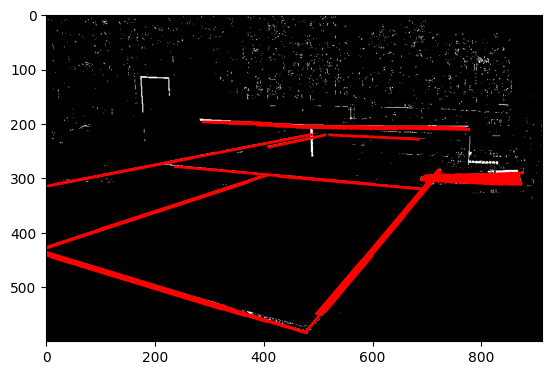

In [6]:
hough_lines = cv.HoughLinesP(
    image=im_thresh,
    rho=1,
    theta=np.pi / 180,
    threshold=75,
    minLineLength=50,
    maxLineGap=15,
)[:, 0, :]


_, ax1 = plt.subplots()
ax1.imshow(im_thresh, cmap="gray")
plot_segments(ax1, hough_lines, colors=["red"], linewidths=[2])
print(hough_lines.shape)

(11, 4)


<Figure size 640x480 with 0 Axes>

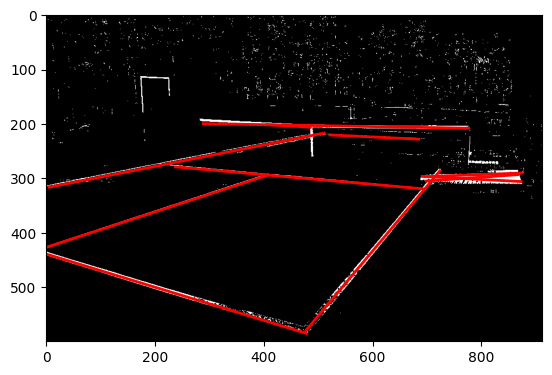

In [7]:
avg_lines = cluster_segments(hough_lines)["average_lines"]

# extend the lines by 10% to guarantee intersections
x1 = avg_lines[:, 0]
y1 = avg_lines[:, 1]
x2 = avg_lines[:, 2]
y2 = avg_lines[:, 3]
v12 = (avg_lines[:, 0:2] - avg_lines[:, 2:4])
extended_avg_lines = avg_lines.copy()
extended_avg_lines[:, 0:2] -= v12 * 0.05
extended_avg_lines[:, 2:4] += v12 * 0.05

plt.figure()
_, ax2 = plt.subplots()
ax2.imshow(im_thresh, cmap="gray")
plot_segments(ax2, extended_avg_lines, colors=["red"], linewidths=[2])
print(avg_lines.shape)